Started processing strategy: 1_


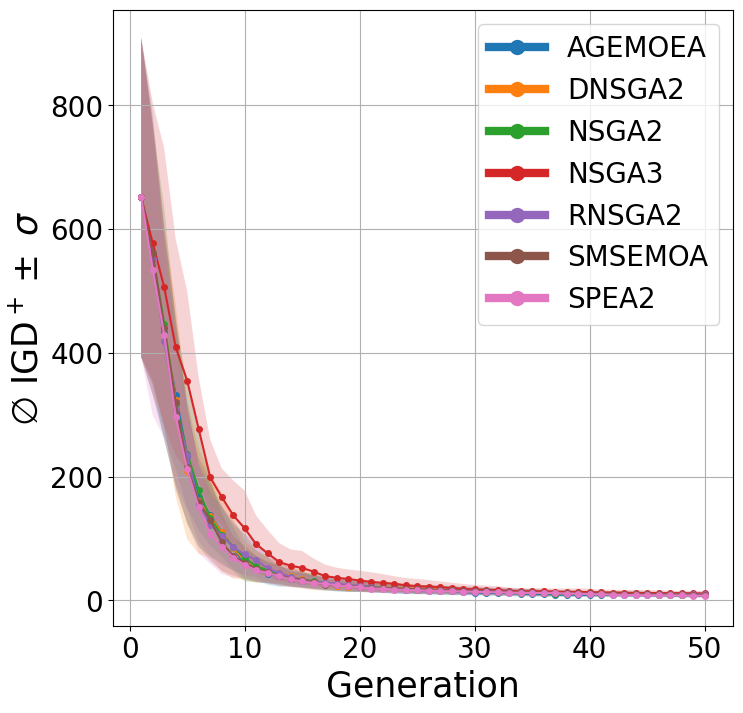

Started processing strategy: 2_


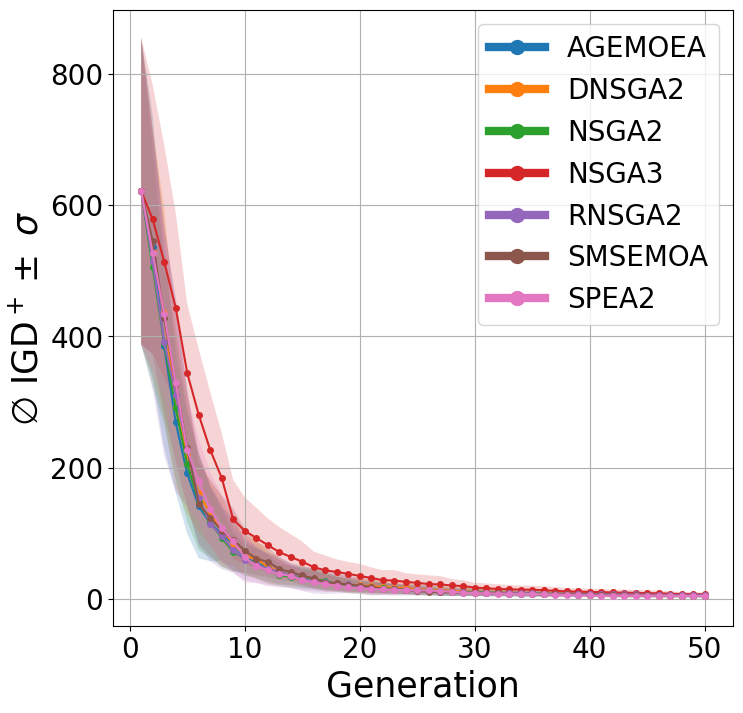

Started processing strategy: 3_


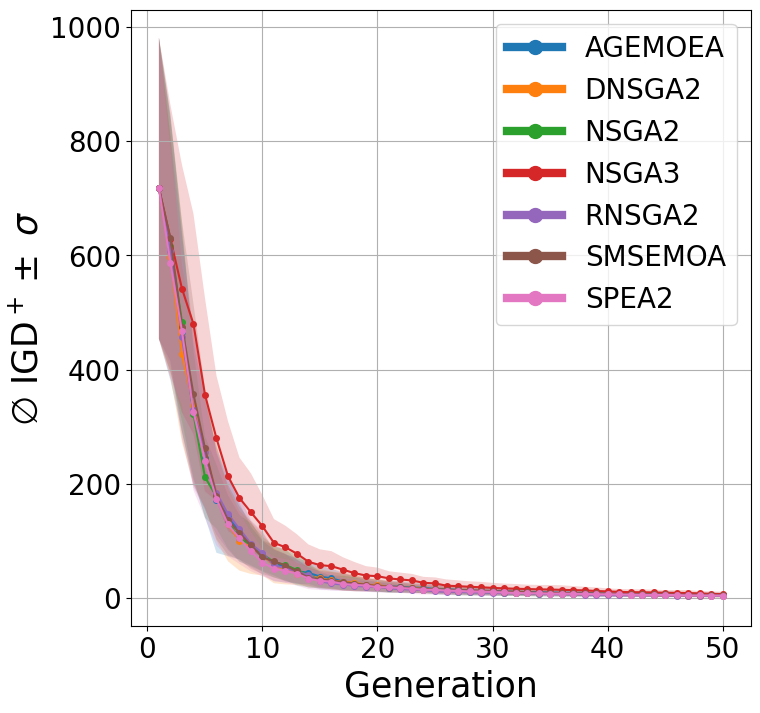

Started processing strategy: 4_


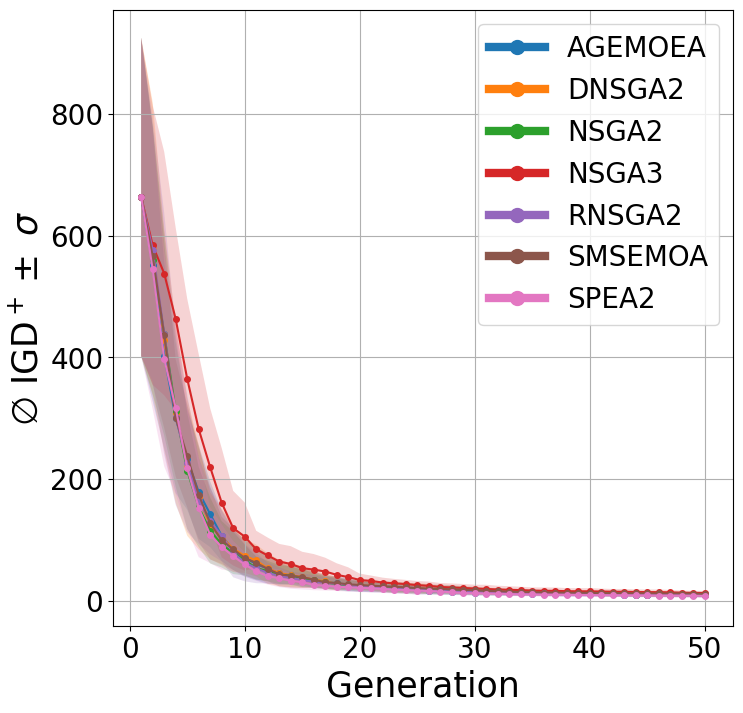

Started processing strategy: 5_


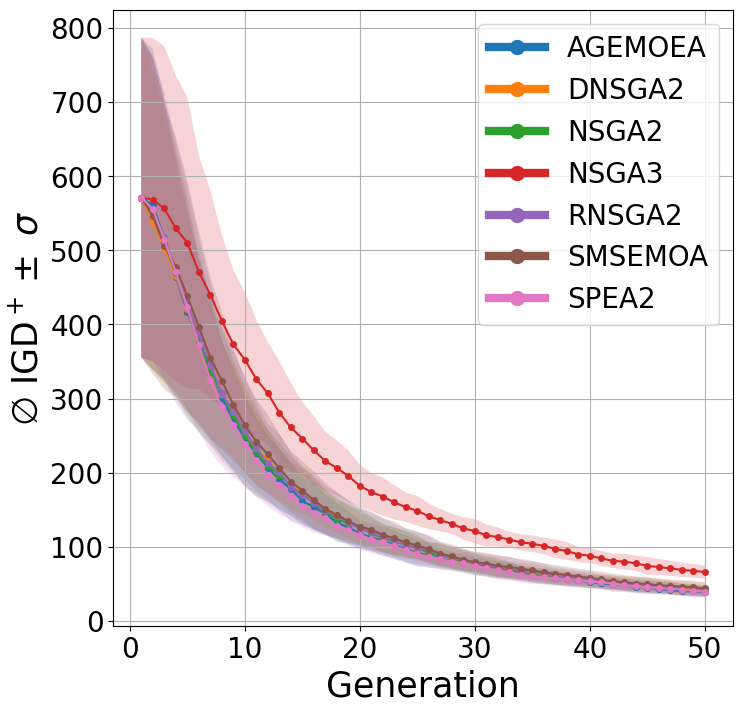

In [4]:
import os
import re
import pandas as pd
import numpy as np
from pymoo.indicators.igd_plus import IGDPlus
import matplotlib.pyplot as plt

# Directory containing the log folders
base_dir = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/meanderingRiverMap'
#base_dir = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/gradientMap'
#base_dir = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/radialGradientMap'
#base_dir = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/log_all_final/sinusoidalMap'

# List of algorithms to analyze
algorithms = ["_AGEMOEA_", "_DNSGA2_", "_NSGA2_", "_NSGA3_", "_RNSGA2_", "_SMSEMOA_", "_SPEA2_"]

# List of shifting strategies to analyze
shifting_strategies = ["1_", "2_", "3_", "4_", "5_"]

# Base directory for true Pareto fronts
true_pareto_base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts/non_dominated_meanderingRiverMap_{}_objective_values.csv'
#true_pareto_base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts/non_dominated_gradientMap_{}_objective_values.csv'
#true_pareto_base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts/non_dominated_radialGradientMap_{}_objective_values.csv'
#true_pareto_base_path = '/Users/carlonue/Documents/Venvs/pathpave_pymoo/data_analysis/non_dominated_True_Pareto_Fronts/non_dominated_sinusoidalMap_{}_objective_values.csv'

# Number of generations to consider
num_generations = 50

# Loop through each shifting strategy
for strategy in shifting_strategies:
    print(f"Started processing strategy: {strategy}")
    
    # Construct the path for the true Pareto front specific to the current shifting strategy
    true_pareto_path = true_pareto_base_path.format(strategy[0])
    
    # Load the True Pareto Front
    true_pareto_front = pd.read_csv(true_pareto_path)
    true_pareto_array = true_pareto_front.to_numpy()

    # Initialize the IGD+ indicator with the true Pareto front
    igd_plus_indicator = IGDPlus(true_pareto_array)

    # Prepare the plot for the current shifting strategy
    plt.figure(figsize=(8, 8))

    # Dictionary to store mean and std IGD+ values for each algorithm
    igd_dict = {}

    # Loop through each algorithm
    for algorithm in algorithms:
        # Define the pattern to match folder names for the current algorithm and shifting strategy
        pattern = rf'^meanderingRiverObstacles{algorithm}{strategy}\d+$'
        #pattern = rf'^gradientObstacles{algorithm}{strategy}\d+$'
        #pattern = rf'^radialGradientObstacles{algorithm}{strategy}\d+$'
        #pattern = rf'^sinusoidalObstacles{algorithm}{strategy}\d+$'

        # Get all matching folders for this algorithm and shifting strategy
        matching_folders = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if re.match(pattern, f)]

        # Initialize a list to store IGD+ values by seed for the current algorithm and shifting strategy
        igd_plus_values_list = []

        # Loop over each matching folder
        for folder in matching_folders:
            # Load the log data containing the objective values
            opt_log_path = os.path.join(folder, 'optLog.csv')
            opt_log = pd.read_csv(opt_log_path)

            # Convert string representation of objective values into numpy arrays
            opt_log[' objectiveValues'] = opt_log[' objectiveValues'].apply(eval)
            generations_objectives = opt_log[' objectiveValues'].to_numpy()

            # Trim to the first num_generations generations
            generations_objectives = generations_objectives[:num_generations]

            # Calculate IGD+ for each generation
            igd_plus_values = [igd_plus_indicator.do(np.array(gen)) for gen in generations_objectives]

            # Store in list
            igd_plus_values_list.append(igd_plus_values)

        # Convert the list of lists into a numpy array
        igd_plus_array = np.array(igd_plus_values_list)

        if igd_plus_array.size > 0:
            # Calculate the mean and standard deviation along the first axis (across seeds)
            mean_igd_plus = np.mean(igd_plus_array, axis=0)
            std_igd_plus = np.std(igd_plus_array, axis=0)

            # Store the results in the dictionary
            igd_dict[algorithm] = (mean_igd_plus, std_igd_plus)

    # Plotting all algorithms for the current shifting strategy
    for algo, (mean_igd_plus, std_igd_plus) in igd_dict.items():
        if len(mean_igd_plus) > 0:
            plt.plot(range(1, len(mean_igd_plus) + 1), mean_igd_plus, marker='o', markersize=4, label=f'{algo.strip("_")}')
            plt.fill_between(range(1, len(mean_igd_plus) + 1), mean_igd_plus - std_igd_plus, mean_igd_plus + std_igd_plus, alpha=0.2)

    # Final plot adjustments for the current shifting strategy
    plt.xlabel('Generation', fontsize=25)
    plt.ylabel(r'$\varnothing$ IGD$^+ \pm$ $\sigma$', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax = plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(20)
    
    #plt.title('Hypervolume Over Generations for Different Algorithms')
    legend = plt.legend(fontsize=20)
    for line in legend.get_lines():
        line.set_linewidth(6)
        line.set_markersize(10)
    
    plt.grid(True)
    plt.show()